<a href="https://colab.research.google.com/github/massimocipressi/MLPNS_MCipressi/blob/main/transformers/assess_TS_classification_w_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries classification with a Transformer model

**Author:** [Theodoros Ntakouris](https://github.com/ntakouris)<br>
**Date created:** 2021/06/25<br>
**Last modified:** 2021/08/05<br>
**Description:** This notebook demonstrates how to do timeseries classification using a Transformer model.

THIS KERAS EXAMPLE OF APPLICATION OF TRANSFORMERS TO TIME SERIES ANALYSIS IS **WRONG**

My student Willow Fox Fortino found that out... 

## Introduction

This is the Transformer architecture from
[Attention Is All You Need](https://arxiv.org/abs/1706.03762),
applied to timeseries instead of natural language.

This example requires TensorFlow 2.4 or higher.

## Load the dataset

We are going to use the same dataset and preprocessing as the
[TimeSeries Classification from Scratch](https://keras.io/examples/timeseries/timeseries_classification_from_scratch)
example.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/MLPNS2023/

[Errno 2] No such file or directory: '/content/drive/MyDrive/MLPNS2023/'
/content


In [3]:
import numpy as np


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

# TASK 1: 

the author provide no data exploration. That is not acceptable. Explore the data

In [4]:
x_train.shape

(3601, 500, 1)

In [7]:
import matplotlib as plt
import pylab as pl
import numpy as np

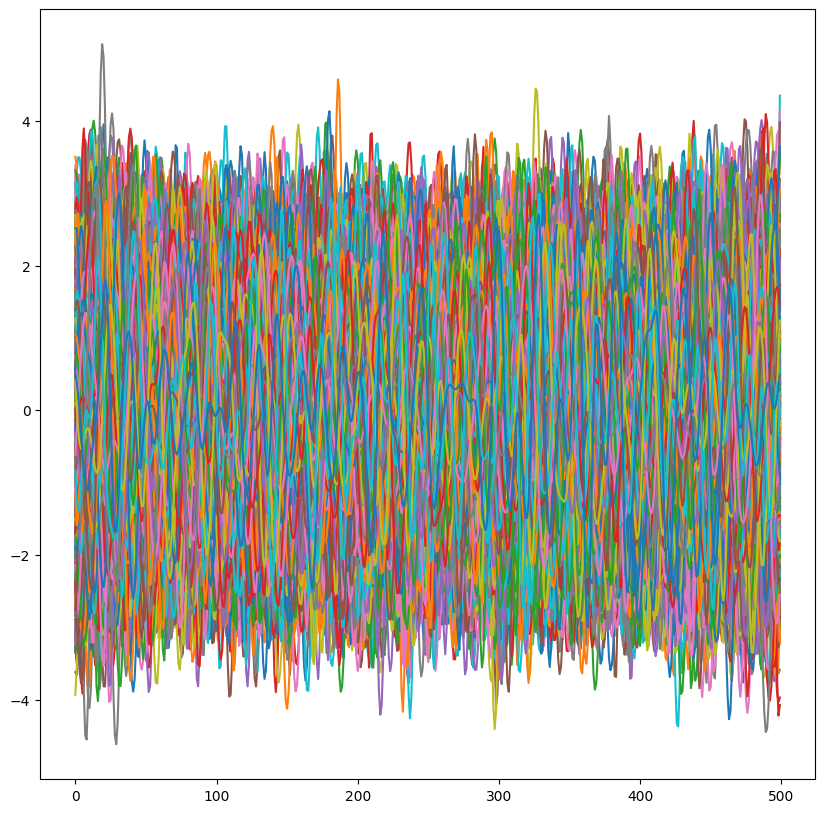

In [10]:
ax = pl.figure(figsize=((10,10))).add_subplot(111)

for i in range(x_train.shape[0]):
  ax.plot(x_train[i][:])

In [11]:
data = np.reshape(x_train,(3601*500,1))

(array([1.60000e+02, 5.26700e+03, 7.14200e+04, 3.37509e+05, 6.42604e+05,
        5.28731e+05, 1.88084e+05, 2.55490e+04, 1.16300e+03, 1.30000e+01]),
 array([-4.6176935 , -3.65000139, -2.68230928, -1.71461717, -0.74692506,
         0.22076705,  1.18845916,  2.15615127,  3.12384338,  4.09153549,
         5.0592276 ]),
 <BarContainer object of 10 artists>)

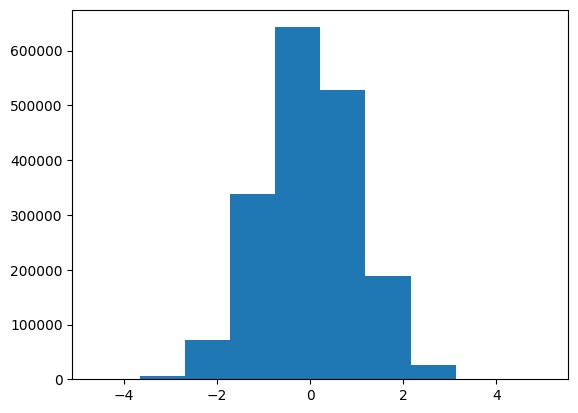

In [12]:
pl.hist(data)

In [22]:
from sklearn import preprocessing

x_train = np.reshape(x_train,(3601,500))

x_train_2 = preprocessing.scale(x_train,axis=0)

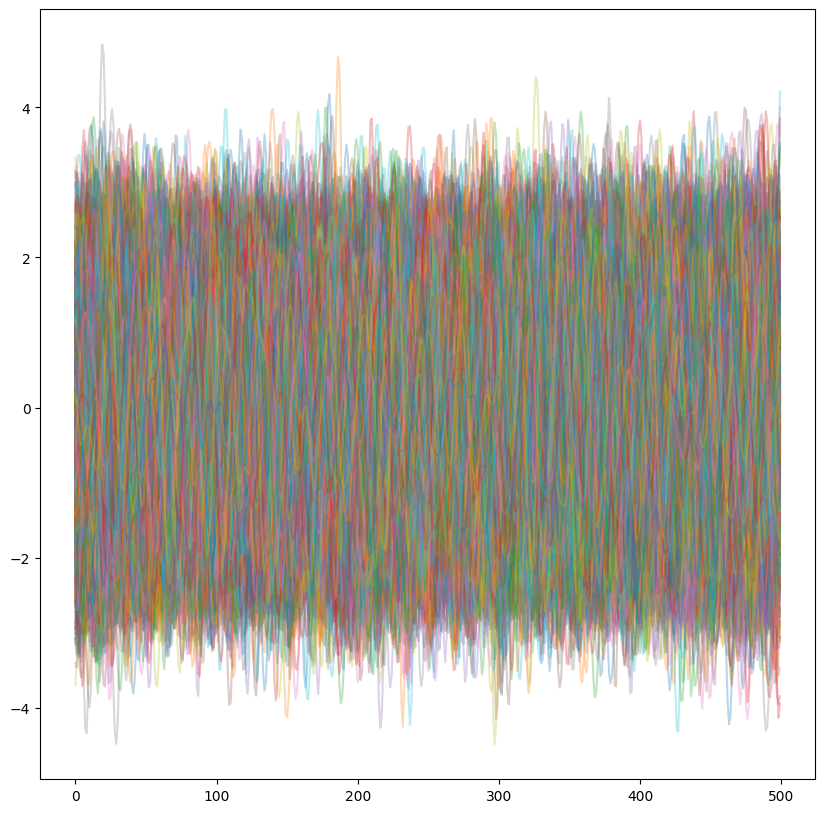

In [32]:
ax = pl.figure(figsize=((10,10))).add_subplot(111)

for i in range(x_train_2.shape[0]):
  ax.plot(x_train_2[i][:],alpha=0.3)

In [ ]:
np.std(x_train_2,axis=0)
np.mean(x_train_2,axis=0)

(array([2.22000e+02, 6.33100e+03, 7.53800e+04, 3.28001e+05, 6.16158e+05,
        5.29299e+05, 2.09011e+05, 3.41250e+04, 1.93900e+03, 3.40000e+01]),
 array([-4.48746057, -3.554645  , -2.62182943, -1.68901387, -0.7561983 ,
         0.17661727,  1.10943283,  2.0422484 ,  2.97506397,  3.90787954,
         4.8406951 ]),
 <BarContainer object of 10 artists>)

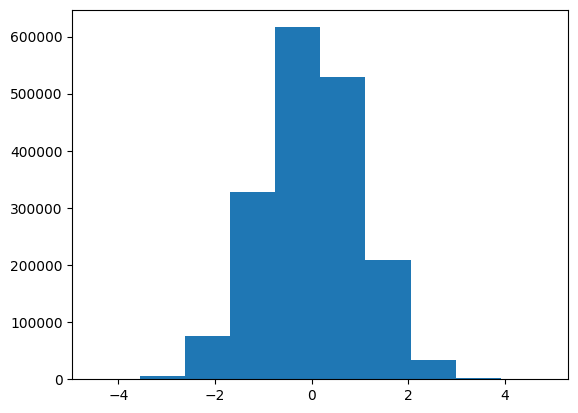

In [27]:
data = np.reshape(x_train_2,(3601*500,1))
pl.hist(data)

(array([1846.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1755.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

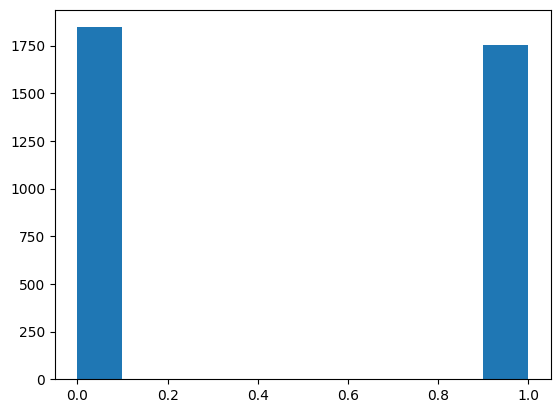

In [31]:
pl.hist(y_train)

In [ ]:
#si potevano fare un po' di cose per label

## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

In [33]:
x_train = np.reshape(x_train_2,(3601,500,1))

In [34]:
from tensorflow import keras
from tensorflow.keras import layers

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [35]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res


The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [ ]:

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


## Train and evaluate

In [ ]:
input_shape = x_train.shape[1:]

"""
create a model with :
4 multiattention heads each size 256, 
4 transformer blocks
4 neurons in the convolutional layers
128 neurons in the feed forward layers
dropout 40% on the transformer layers
dropout 25% on the feed forward layers

compile it with a sparse_categorical_crossentropy,
choose the kearas adam optimizer with a learning rate of 1e-4
monitor the sparse_categorical_accuracy metric
"""

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)

model = keras.models.load_model('transformer_h4_model.h5')
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, 
                                           restore_best_weights=True)]



Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization_32 (LayerN  (None, 500, 1)      2           ['input_5[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_16 (Multi  (None, 500, 1)      7169        ['layer_normalization_32[0][0]', 
 HeadAttention)                                                   'layer_normalization_32[0][0]'] 
                                                                                            

In [ ]:
with open('/transformer_h4_history', "rb") as file_pi:
    history_4h = pickle.load(file_pi)
   

In [ ]:
import pylab as plt
print accuracy and loss

plot the history .... what do you see?

## Conclusions

Official version: In about 110-120 epochs (25s each on Colab), the model reaches a training
accuracy of ~0.95, validation accuracy of ~84 and a testing
accuracy of ~85, without hyperparameter tuning. And that is for a model
with less than 100k parameters. Of course, parameter count and accuracy could be
improved by a hyperparameter search and a more sophisticated learning rate
schedule, or a different optimizer.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/timeseries_transformer_classification) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/timeseries_transformer_classification).

**Reality** these transformer blocks are not doing anything! 
- there is no positional encoding
- the time series are 1D and its not clear that the performance holds going from multivariate (tockenized) to univariate


In [ ]:
input_shape = x_train.shape[1:]

"""
create another model with :
1 multiattention head size 256, 
0 transformer blocks
4 neurons in the convolutional layers
128 neurons in the feed forward layers
dropout 40% on the transformer layers
dropout 25% on the feed forward layers

compile it with a sparse_categorical_crossentropy,
choose the kearas adam optimizer with a learning rate of 1e-4
monitor the sparse_categorical_accuracy metric
"""

model.summary()

   

print accuracy and loss

plot the history .... what do you see?